In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import os
# os.chdir("../../pykan/kan/")
# from KAN import KAN
from Scaled_KAN import *

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size_train = 32
batch_size_test = 32
lr_conv = 0.0001
lr_kan  = 0.001
momentum_conv = 0.9
momentum_kan = 0.9

tasks = 10

In [13]:
# Create conventional MLP model
class NN(nn.Module):

    def __init__(self):
        super(NN, self).__init__()
        # 28*28 input image, 128 output units, 10 output units
        self.fc1 = nn.Linear(28*28, 2**7)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 28*28)
        # Pass through the first layer
        x = F.relu(self.fc1(x))
        # Pass through the second layer
        x = self.fc2(x)
        # Apply log softmax
        x = F.log_softmax(x, dim=1)
        return x

model = NN()
model.to(device)
print(f"Conventional model: {model}")

# Create KAN model
KAN_model = FastKAN(layers_hidden=[28*28,2**5,10], grid_min=2, grid_max=4, device=device)
KAN_model.to(device)
# KAN_model = KAN(width=[28*28,32,10], grid=5, k=3, seed=0)

print(f"KAN model: {KAN_model}")

Conventional model: NN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
KAN model: FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=6272, out_features=32, bias=False)
      (base_linear): Linear(in_features=784, out_features=32, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=256, out_features=10, bias=False)
      (base_linear): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)


In [14]:
import numpy as np

# Transform the MNIST dataset to a tensor and normalising it
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307),(0.3081)), # Normalise samples using the mean of 0.1307 and std of 0.3081 - extracted after manual analysis
    T.Lambda(lambda x: torch.flatten(x))
])
train_set = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('../data', train=False, download=True, transform=transform)

optimizer = optim.Adam(model.parameters(), lr=lr_conv)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_conv)
loss_fn = nn.CrossEntropyLoss()


optimizer_KAN = optim.Adam(KAN_model.parameters(), lr=lr_KAN)
scheduler_KAN = optim.lr_scheduler.ExponentialLR(optimizer_KAN, gamma=lr_KAN)
loss_fn_KAN = nn.CrossEntropyLoss()

# Pair numbers together and create 5 tasks
tasks = [(i,i+1) for i in range(0,10,2)]

# For training: fill splitted_train array with examples where the target value is in task i
targets = train_set.targets.numpy()
splitted_train = []
for task in tasks:
    indices = np.where(np.isin(targets, task))[0]
    subset = [train_set[i] for i in indices]
    splitted_train.append(subset)

# For testing: fill splitted_train array with examples where the target value is in task i
targets = test_set.targets.numpy()
splitted_test = []
for task in tasks:
    indices = np.where(np.isin(targets, task))[0]
    subset = [test_set[i] for i in indices]
    splitted_test.append(subset)


torch.Size([784])


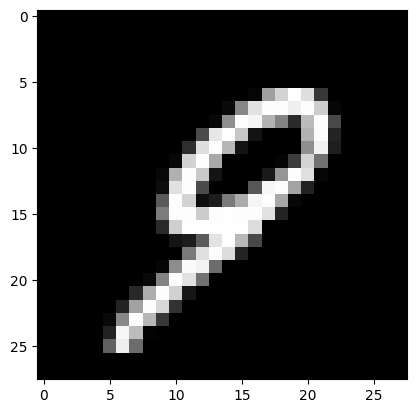

In [15]:
# Visualise a random image to check if the data is loaded correctly
rand_image = random.choice(splitted_train[4])
print(rand_image[0].shape)
plt.imshow(rand_image[0].numpy().reshape(28,28), cmap='gray')
plt.show()

Training on 0
12665 2115
Epoch 0:
Conventional model: Train accuracy: 47.82, Test accuracy: 70.97    VS   KAN model: Train accuracy: 34.80, Test accuracy: 39.15
Epoch 1:
Conventional model: Train accuracy: 82.30, Test accuracy: 91.96    VS   KAN model: Train accuracy: 42.35, Test accuracy: 47.47
Epoch 2:
Conventional model: Train accuracy: 94.24, Test accuracy: 96.69    VS   KAN model: Train accuracy: 50.56, Test accuracy: 55.74
Epoch 3:
Conventional model: Train accuracy: 97.09, Test accuracy: 98.01    VS   KAN model: Train accuracy: 59.83, Test accuracy: 67.90
Epoch 4:
Conventional model: Train accuracy: 98.06, Test accuracy: 98.68    VS   KAN model: Train accuracy: 70.09, Test accuracy: 77.45
Epoch 5:
Conventional model: Train accuracy: 98.54, Test accuracy: 98.87    VS   KAN model: Train accuracy: 79.34, Test accuracy: 84.73
Epoch 6:
Conventional model: Train accuracy: 98.74, Test accuracy: 99.05    VS   KAN model: Train accuracy: 85.91, Test accuracy: 89.60
Epoch 7:
Conventional m

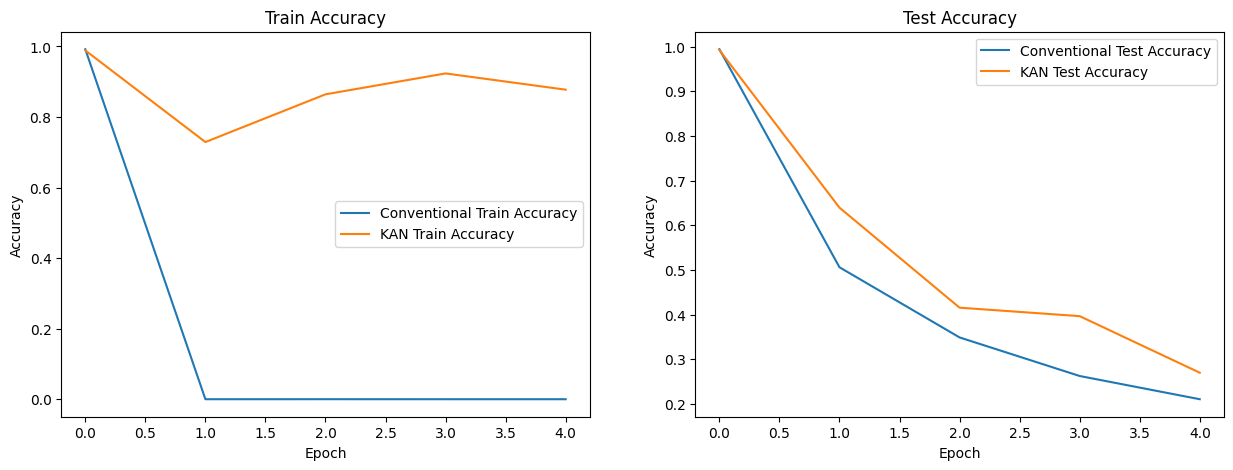

In [16]:
# Train the KAN
performance = []
train_accs_conv = []
test_accs_conv = []
train_accs_kan = []
test_accs_kan = []

for task in range(len(tasks)):
    print(f"Training on {task}")

    # Create dataloader with the splitted training and testing sets
    train_loader = torch.utils.data.DataLoader(
        splitted_train[task],
        batch_size=batch_size_train,
        shuffle=True
    )

    # Accumulate testing samples into performance array to evaluate forgetting of previous tasks
    performance.extend(splitted_test[task])
    
    test_loader = torch.utils.data.DataLoader(
        performance, 
        batch_size=batch_size_test, 
        shuffle=True
    )

    # # Visualise a random image to check if the data is loaded correctly
    # rand_image = random.choice(performance)
    # print(rand_image[0][0].shape)
    # plt.imshow(rand_image[0][0].numpy().reshape(28,28))
    # plt.show()
    
    print(len(train_loader.dataset), len(test_loader.dataset))
    
    for epoch in range(20):
        # Train the conventional model
        model.train()
        correct = 0

        # Train the KAN model
        # dataset = {
        #     'train_input': torch.cat([data for data, _ in train_loader]),
        #     'train_label': torch.cat([target for _, target in train_loader]),
        #     'test_input': torch.cat([data for data, _ in test_loader]),
        #     'test_label': torch.cat([target for _, target in test_loader])
        # }

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        train_acc_conv = correct / len(train_loader.dataset)
        
        # Train the KAN model
        KAN_model.train()
        correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer_KAN.zero_grad()
            output = KAN_model(data)
            loss = loss_fn_KAN(output, target)
            loss.backward()
            optimizer_KAN.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        train_acc_kan = correct / len(train_loader.dataset)

        train_acc = [train_acc_conv, train_acc_kan]

        KAN_model.eval()
        model.eval()
        test_loss = [0,0]
        correct = [0,0]

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = [model(data),KAN_model(data)]
                test_loss[0] += loss_fn(output[0], target).item() * data.size(0)
                test_loss[1] += loss_fn(output[1], target).item() * data.size(0)
                pred = [output[0].argmax(dim=1, keepdim=True), output[1].argmax(dim=1, keepdim=True)]
                correct[0] += pred[0].eq(target.view_as(pred[0])).sum().item()
                correct[1] += pred[1].eq(target.view_as(pred[1])).sum().item()
        test_loss[0] /= len(test_loader.dataset)
        test_loss[1] /= len(test_loader.dataset)
        
        test_acc = [0,0]
        test_acc[0] = correct[0] / len(test_loader.dataset)
        test_acc[1] = correct[1] / len(test_loader.dataset)

        # Update the learning rate
        scheduler.step()
        # print training and testing accuracy for each model
        print(f"Epoch {epoch}:")
        print(f"Conventional model: Train accuracy: {train_acc[0]*100:.2f}, Test accuracy: {test_acc[0]*100:.2f}    VS   KAN model: Train accuracy: {train_acc[1]*100:.2f}, Test accuracy: {test_acc[1]*100:.2f}")

    # Store accuracies for plotting
    train_accs_conv.append(train_acc[0])
    test_accs_conv.append(test_acc[0])
    train_accs_kan.append(train_acc[1])
    test_accs_kan.append(test_acc[1])
    
# Plot accuracies
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_accs_conv, label='Conventional Train Accuracy')
axs[0].plot(train_accs_kan, label='KAN Train Accuracy')
axs[0].set_title('Train Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(test_accs_conv, label='Conventional Test Accuracy')
axs[1].plot(test_accs_kan, label='KAN Test Accuracy')
axs[1].set_title('Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

torch.save(model.state_dict(), "mnist_model.pth")

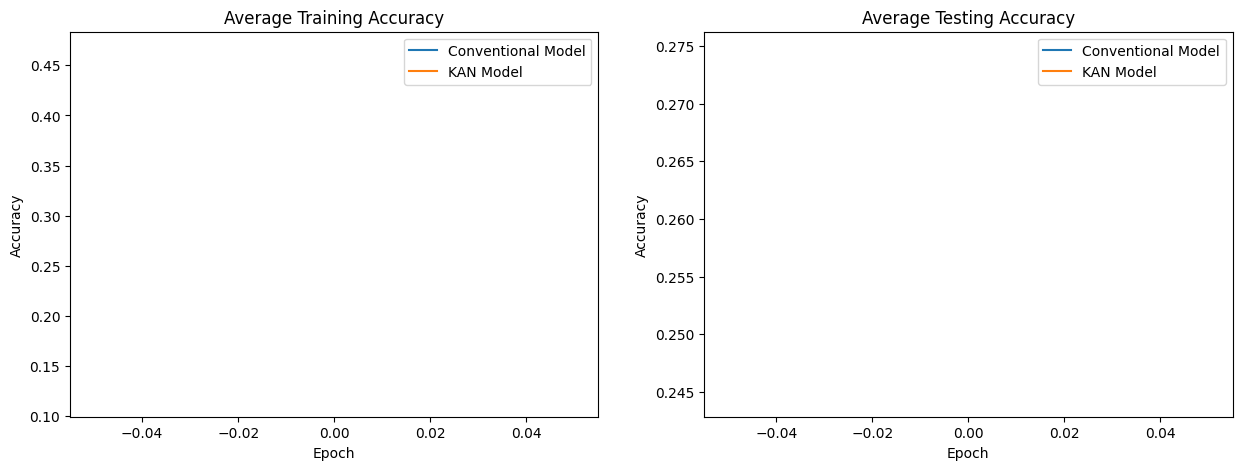

In [6]:
# now plot the average accuracy per epoch for both models
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

conv_acc = [sum(train_accs_conv[i:i+10])/10 for i in range(0, len(train_accs_conv), 10)]
kan_acc = [sum(train_accs_kan[i:i+10])/10 for i in range(0, len(train_accs_kan), 10)]

axs[0].plot(conv_acc, label='Conventional Model')
axs[0].legend()

axs[0].plot(kan_acc, label='KAN Model')
axs[0].set_title('Average Training Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

#do the same for test accuracy

conv_acc = [sum(test_accs_conv[i:i+10])/10 for i in range(0, len(test_accs_conv), 10)]
kan_acc = [sum(test_accs_kan[i:i+10])/10 for i in range(0, len(test_accs_kan), 10)]

axs[1].plot(conv_acc, label='Conventional Model')
axs[1].legend()

axs[1].plot(kan_acc, label='KAN Model')
axs[1].set_title('Average Testing Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [7]:
with torch.no_grad():
    # Test a test_loader example
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
                    #     'test_label': torch.cat([target for _, target in test_loader])
    #choose only the data for which target is above 7
    # data = data[target>7]
    # target = target[target>7]
    print(f"Targer   : {target}")
    print(f"KAN model: {KAN_model(data).argmax(dim=1)}")


Targer   : tensor([1, 7, 8, 2, 3, 2, 7, 6, 4, 5, 2, 4, 9, 7, 1, 9, 3, 3, 1, 8, 0, 1, 0, 4,
        8, 8, 1, 6, 1, 0, 9, 4], device='cuda:0')
KAN model: tensor([8, 7, 8, 8, 8, 8, 9, 9, 9, 8, 8, 8, 9, 9, 8, 9, 8, 8, 9, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 9, 9, 8], device='cuda:0')


In [8]:
model = FastKAN(layers_hidden=[28*28,64,10], grid_min=3, grid_max=5, device=device)
model.load_state_dict(torch.load("mnist_model.pth"))
model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for FastKAN:
	Missing key(s) in state_dict: "layers.0.layernorm.weight", "layers.0.layernorm.bias", "layers.0.rbf.grid", "layers.0.spline_linear.weight", "layers.0.base_linear.weight", "layers.0.base_linear.bias", "layers.1.layernorm.weight", "layers.1.layernorm.bias", "layers.1.rbf.grid", "layers.1.spline_linear.weight", "layers.1.base_linear.weight", "layers.1.base_linear.bias". 
	Unexpected key(s) in state_dict: "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 

In [ ]:
layers = []
for layer in model.modules():
    layers.append(layer)
    print("====> Layer ", layer)
layer = layers[1]
# # for i in range(layer.input_dim):
# for j in range(layer.output_dim):
#     # layer.set_curve(i, j, torch.tensor([0.0, 1.0, 0.0], device=device))
#     x, y = layer.plot_curve(0, j, num_pts=100, num_extrapolate_bins=3)
#     plt.plot(x.to('cpu').numpy(), y.to('cpu').numpy(), label=f"Last Layer, Input 0, Output {j}")
# # plt.legend()
# plt.show()

====> Layer  FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=6272, out_features=64, bias=False)
      (base_linear): Linear(in_features=784, out_features=64, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=10, bias=False)
      (base_linear): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)
====> Layer  ModuleList(
  (0): FastKANLayer(
    (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
    (rbf): RadialBasisFunction()
    (spline_linear): SplineLinear(in_features=6272, out_features=64, bias=False)
    (base_linear): Linear(in_features=784, out_features=64, bias=True)
  )
  (1): FastKANLayer(
    (layernorm): LayerNorm((64,), eps=

In [ ]:
# for each pixel of the given input image, given a layer an input and an output, give me the gradient of the weights
def get_gradient(model, layer, input, output):
    model.zero_grad()
    output = model(input)
    output = F.softmax(output, dim=1)
    loss = F.cross_entropy(output, output)
    loss.backward()
    return layer.weight.grad

AttributeError: 'FastKANLayer' object has no attribute 'curve'